# Exploring OpenAI Image Edit Features via API

This notebook demonstrates how to use the OpenAI API to edit images programmatically. You'll learn how to authenticate, upload images, send edit requests, and visualize results.

## 1. Setup OpenAI API Key

To use the OpenAI API, you'll need an API key. Store your key securely and avoid sharing it publicly.

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found. Please set it in your .env file.")

import openai
openai.api_key = OPENAI_API_KEY

In [ ]:
img_path = 'image1.png'  # Set your image path here

from PIL import Image
img = Image.open(img_path)
img_size = img.size  # (width, height)
print(f"Image size: {img_size}")

## 2. Show Image and Create Image Mask

This section allows you to interactively view your image and create a mask using rectangle selection. The mask can be used for image editing with the OpenAI API.

✅ Image loaded: (1024, 1024) pixels
📡 Click event connected with ID: 15


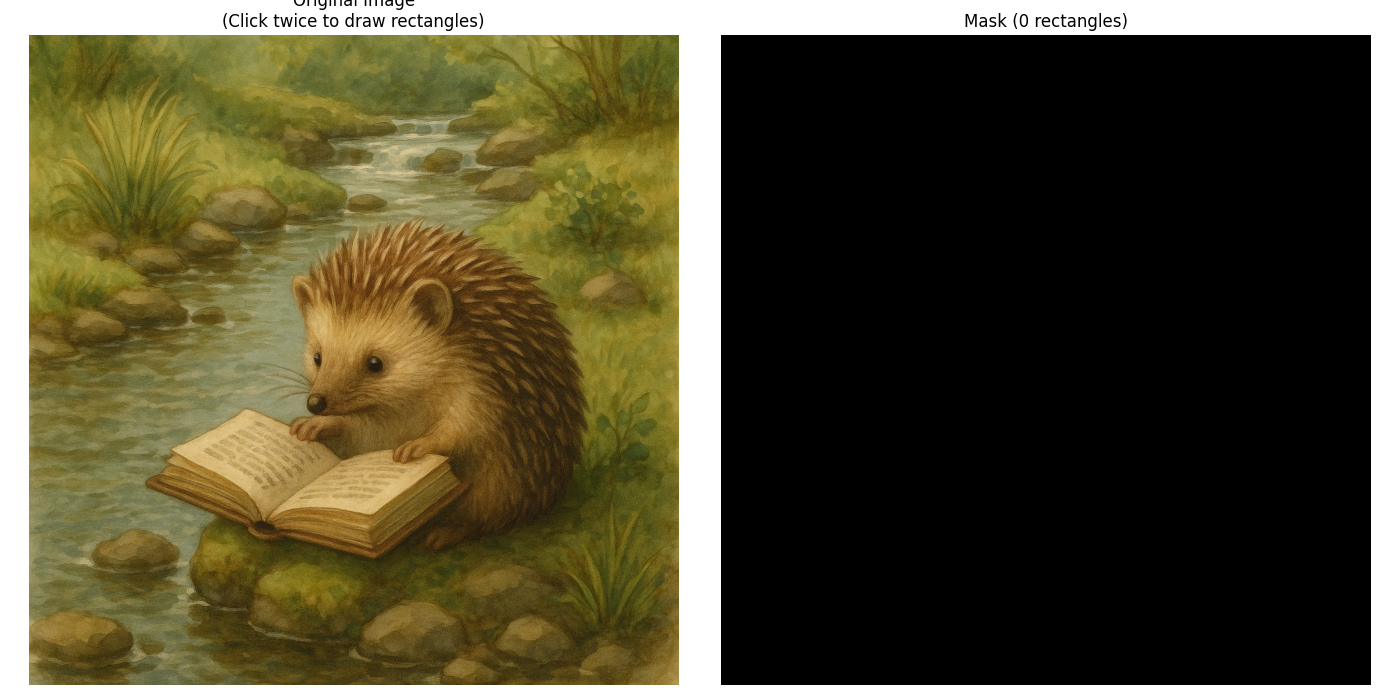


🎮 Interactive Instructions:
1. Click ONCE on the left image to start drawing a rectangle
2. Click ONCE again to finish the rectangle
3. Repeat to add more rectangles
4. Each rectangle will be numbered and highlighted in red


In [26]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

# Disable interactive navigation to prevent pan/zoom interference
plt.rcParams['toolbar'] = 'None'

# --- Load your RGBA image ---
img_path = 'image1.png'  # replace with your image path
img = Image.open(img_path).convert('RGBA')
arr = np.array(img)
alpha = arr[:, :, 3]

print(f"✅ Image loaded: {img.size} pixels")

# --- Generate initial mask of fully transparent pixels ---
initial_mask = (alpha == 0).astype(np.uint8) * 255

# --- Prepare interactive masking ---
mask = np.zeros_like(alpha)  # start with an empty mask
rectangles = []  # Store drawn rectangles

# Global variables for drawing
drawing = False
start_point = None
current_rect = None

def onclick(event):
    global drawing, start_point, current_rect
    
    print(f"🖱️  Click detected: button={event.button}, x={event.xdata}, y={event.ydata}")
    
    if event.inaxes != ax_img:
        print("❌ Click outside image area")
        return
    
    # Only respond to left mouse button
    if event.button != 1:
        print("❌ Not left mouse button")
        return
        
    if event.xdata is None or event.ydata is None:
        print("❌ Invalid coordinates")
        return
        
    if not drawing:
        # Start drawing
        drawing = True
        start_point = (int(event.xdata), int(event.ydata))
        print(f"🎯 Started rectangle at: {start_point}")
    else:
        # Finish drawing
        end_point = (int(event.xdata), int(event.ydata))
        drawing = False
        
        # Add rectangle to mask
        x1, y1 = start_point
        x2, y2 = end_point
        
        # Ensure coordinates are in correct order
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
        
        # Ensure rectangle has some size
        if x_max - x_min < 5 or y_max - y_min < 5:
            print("⚠️  Rectangle too small, making it at least 20x20 pixels")
            x_max = x_min + 20
            y_max = y_min + 20
        
        # Add to mask
        mask[y_min:y_max, x_min:x_max] = 255
        rectangles.append((x_min, y_min, x_max, y_max))
        
        print(f"✅ Added rectangle: ({x_min}, {y_min}) to ({x_max}, {y_max})")
        print(f"📊 Mask now has {(mask > 0).sum()} white pixels")
        
        # Update display
        update_display()

def update_display():
    global fig, ax_img, ax_mask
    
    # Clear and redraw
    ax_img.clear()
    ax_mask.clear()
    
    # Show original image
    ax_img.imshow(img)
    ax_img.set_title('Original Image\n(Click twice to draw rectangles)', fontsize=12)
    ax_img.axis('off')
    
    # Draw rectangles on original image
    for i, (x_min, y_min, x_max, y_max) in enumerate(rectangles):
        rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                        linewidth=3, edgecolor='red', facecolor='red', alpha=0.3)
        ax_img.add_patch(rect)
        
        # Add rectangle number
        ax_img.text(x_min + 5, y_min + 15, f'{i+1}', 
                   color='white', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
    
    # Show current mask
    combined = np.maximum(initial_mask, mask)
    ax_mask.imshow(combined, cmap='gray')
    ax_mask.set_title(f'Mask ({len(rectangles)} rectangles)', fontsize=12)
    ax_mask.axis('off')
    
    plt.tight_layout()
    
    # Force display update
    try:
        fig.canvas.draw_idle()
        fig.canvas.flush_events()
    except:
        fig.canvas.draw()

# Create the plot with navigation disabled
fig, (ax_img, ax_mask) = plt.subplots(1, 2, figsize=(14, 7))

# Disable navigation toolbar for this figure
try:
    fig.canvas.toolbar_visible = False
except:
    print("⚠️  Could not disable toolbar")

# Initial display
update_display()

# Connect the click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)
print(f"📡 Click event connected with ID: {cid}")

# Try to disable default key bindings
try:
    fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
except:
    print("⚠️  Could not disable key bindings")

plt.show()
print("\n🎮 Interactive Instructions:")
print("1. Click ONCE on the left image to start drawing a rectangle")
print("2. Click ONCE again to finish the rectangle")
print("3. Repeat to add more rectangles")
print("4. Each rectangle will be numbered and highlighted in red")

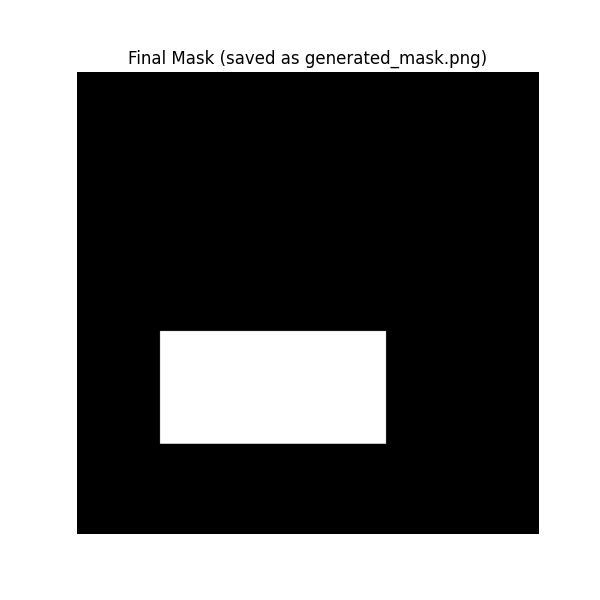

In [27]:
# Save the final mask for use with OpenAI API
if 'mask' in locals() and mask.max() > 0:
    # Combine user-drawn mask with initial transparency mask
    final_mask = np.maximum(initial_mask, mask)
    
    # Convert to PIL Image and save
    from PIL import Image

# final_mask is your numpy array of 0 (keep) / 255 (edit) values
    mask_gray = Image.fromarray(final_mask.astype("uint8"), mode="L")

    # We want transparent (alpha=0) where mask_gray==255 (edit region),
    # and opaque (alpha=255) where mask_gray==0 (keep region):
    alpha = mask_gray.point(lambda p: 255 - p)

    # Build an RGBA image (you can leave RGB channels blank since
    # only alpha matters):
    mask_rgba = Image.new("RGBA", mask_gray.size, color=(0, 0, 0, 0))
    mask_rgba.putalpha(alpha)

    # Save as a proper RGBA PNG
    mask_rgba.save("generated_mask.png")
    
    # Display the final mask
    plt.figure(figsize=(6, 6))
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Mask (saved as generated_mask.png)')
    plt.axis('off')
    plt.show()
else:
    print("No mask created yet. Please run the interactive masking cell above and draw some rectangles.")


## 3. Upload and Prepare Images

Load an image from your local system and prepare it for editing with the OpenAI API.


## 4. Send Image Edit Requests

Use the OpenAI API to send an image edit request. You can specify prompts and parameters for the edit.

In [ ]:
import os
import base64
from dotenv import load_dotenv
from openai import OpenAI

# Load your key
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found. Please set it in your .env file.")

# Initialize the new client
client = OpenAI(api_key=OPENAI_API_KEY)

# Your inputs
mask_path = "generated_mask.png"
# Prompt the user for the edit prompt
prompt = input("Enter your prompt for the image edit: ")

# Compute edited file path based on img_path
base, ext = os.path.splitext(img_path)
edited_path = f"{base}_edited{ext}"

# Call the new edit endpoint (response_format is implicit)
with open(img_path, "rb") as image_file, open(mask_path, "rb") as mask_file:
    result = client.images.edit(
        model="dall-e-2",
        image=image_file,
        mask=mask_file,
        prompt=prompt,
        n=1,
        size=f"{img_size[0]}x{img_size[1]}",
    )
image_url = result.data[0].url
import requests
resp = requests.get(image_url)
resp.raise_for_status()
with open(edited_path, "wb") as f:
    f.write(resp.content)

print(f"Edited image saved to: {edited_path}")

# Display the edited image
from PIL import Image
import matplotlib.pyplot as plt

edited_img = Image.open(edited_path)
plt.figure(figsize=(8, 8))
plt.imshow(edited_img)
plt.axis('off')
plt.title('Edited Image')
plt.show()


Edited image saved to: image1_edited.png
